## Exploratory Data Analysis (EDA) on the cleaned dataset

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
import re
from sklearn.preprocessing import LabelEncoder
import joblib
from wordcloud import WordCloud
from tqdm import tqdm

In [3]:
# load the saved dataset and label encoder
df = pd.read_csv('../data/cleaned_data.csv')
label_encoder = joblib.load('../data/label_encoder.pkl')

In [4]:
df.head()

,text,category
0,million american roll sleev omicrontarget covi...,35
1,american airlin flyer charg ban life punch fli...,35
2,funniest tweet cat dog week sept dog dont unde...,5
3,funniest tweet parent week sept accident put g...,22
4,woman call cop black birdwatch lose lawsuit ex...,35


In [5]:
df['label'] = label_encoder.inverse_transform(df['category'])

In [6]:
df.head()

,text,category,label
0,million american roll sleev omicrontarget covi...,35,U.S. NEWS
1,american airlin flyer charg ban life punch fli...,35,U.S. NEWS
2,funniest tweet cat dog week sept dog dont unde...,5,COMEDY
3,funniest tweet parent week sept accident put g...,22,PARENTING
4,woman call cop black birdwatch lose lawsuit ex...,35,U.S. NEWS


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      209512 non-null  object
 1   category  209527 non-null  int64 
 2   label     209527 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.8+ MB


C:\Users\caaka\AppData\Local\Temp\ipykernel_15040\3448739275.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='viridis')


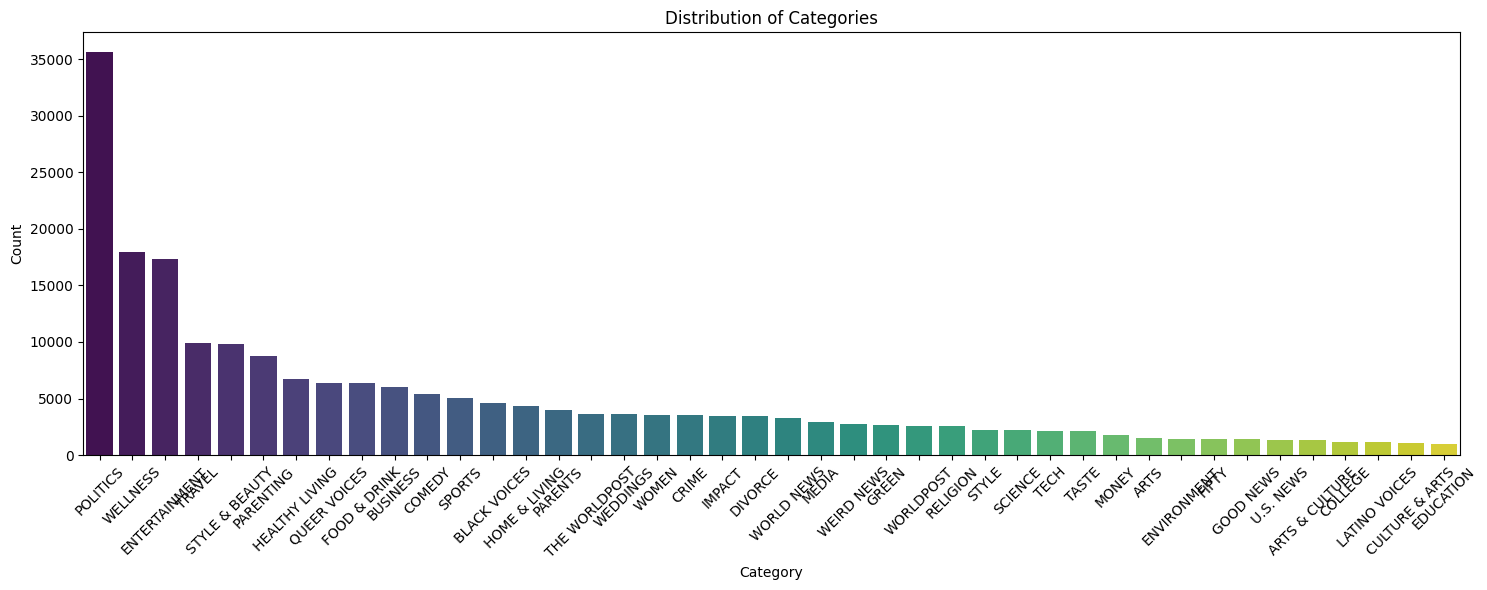

In [8]:
# Count plot of each category
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='viridis')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/plots/category_distribution.png')
plt.show()

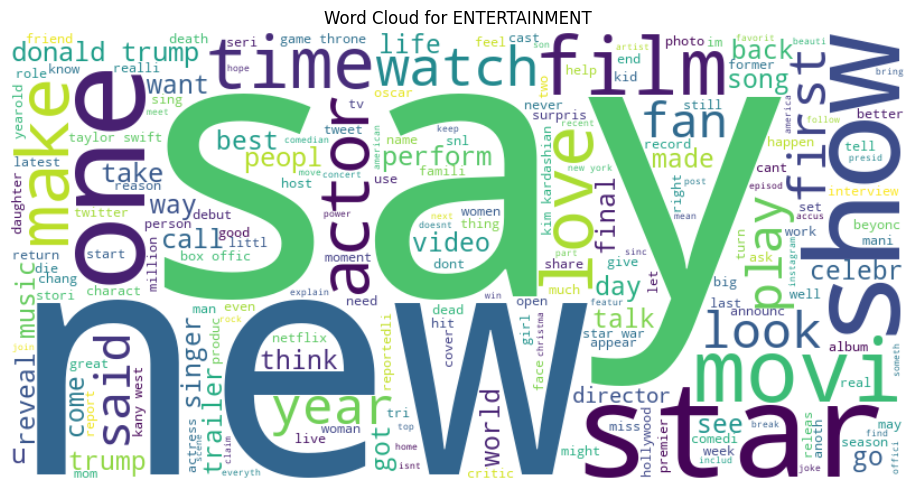

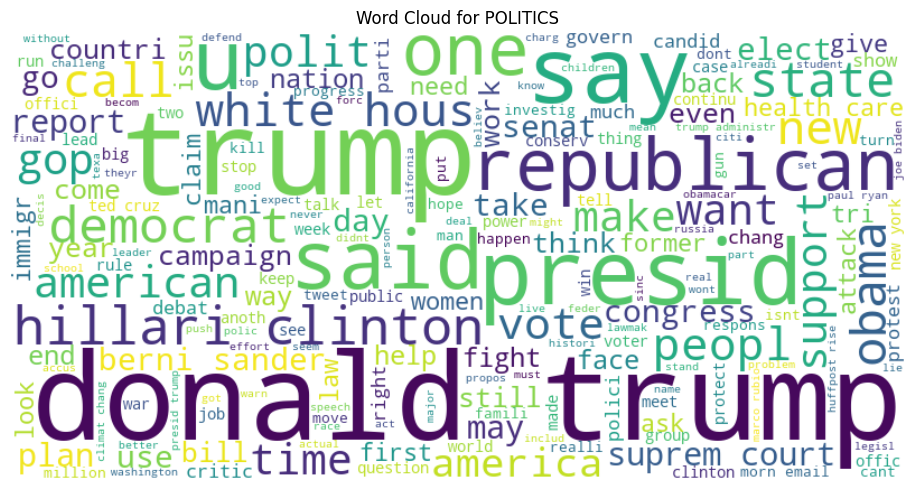

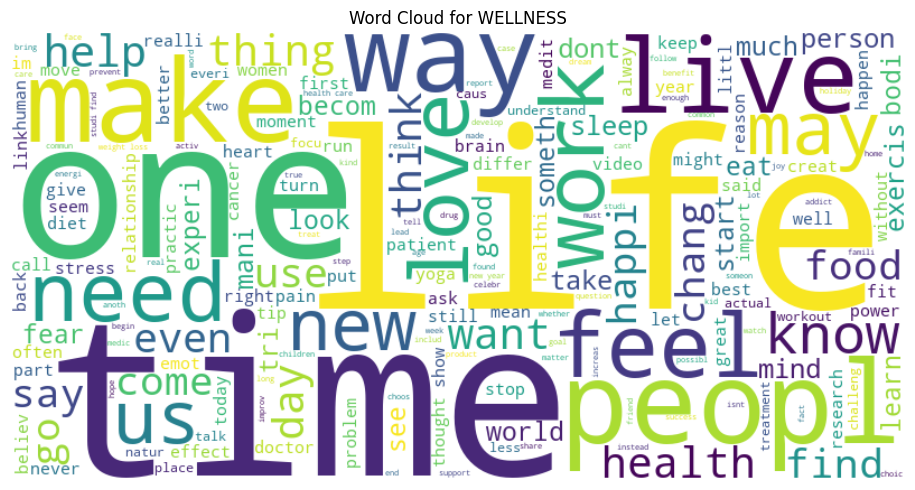

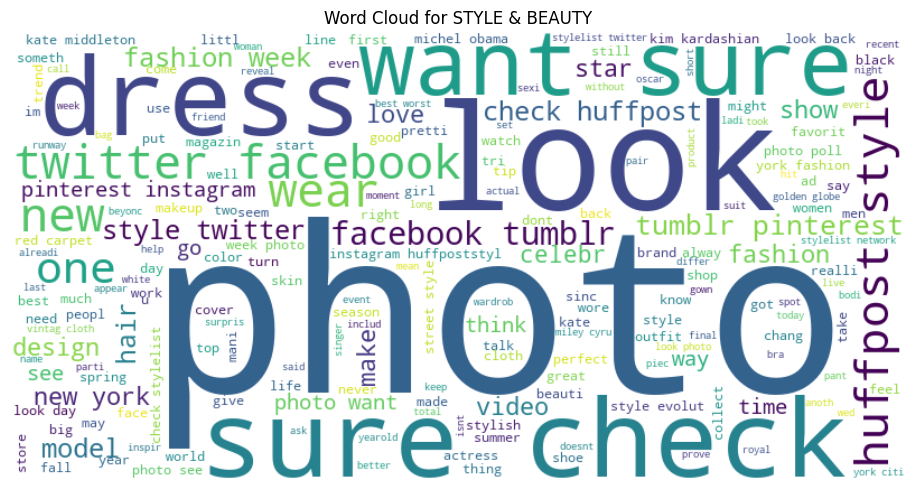

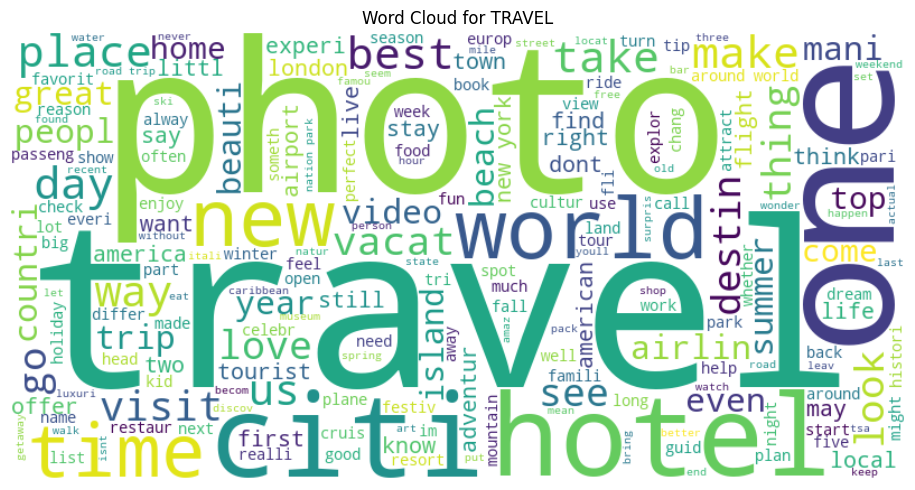

In [9]:
# Word cloud for each category
def plot_wordcloud(text, category):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {category}')
    plt.tight_layout()
    plt.savefig(f'../outputs/plots/wordcloud_{category}.png')
    plt.show()

# Generate word clouds for first 5 categories
df_cat = df[df['label'].isin(df['label'].value_counts().index[:5])]
categories = df_cat['label'].unique()
for category in categories:
    text = ' '.join(df_cat[df_cat['label'] == category]['text'].fillna('').astype(str))
    plot_wordcloud(text, category)

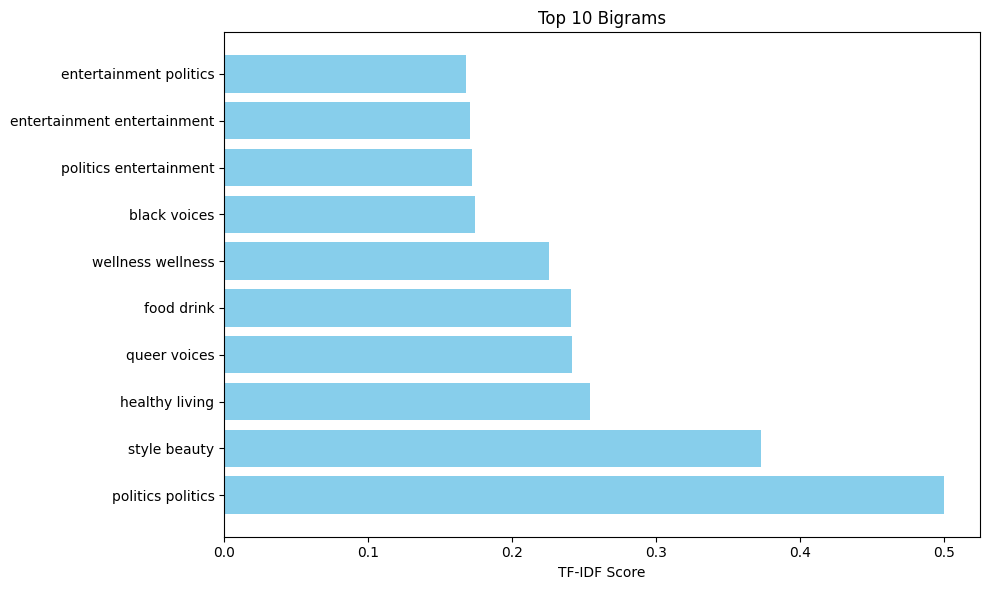

In [38]:
# Bigram analysis for first all categories using tfidf
def top_n_bigrams(text, n=10):
    vectorizer = TfidfVectorizer(ngram_range=(2, 2), stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([text])
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()[0]
    top_n_indices = np.argsort(tfidf_scores)[-n:][::-1]
    return [(feature_names[i], tfidf_scores[i]) for i in top_n_indices]

# Generate bigrams for first all categories
df_bigram = df[df['label'].isin(df['label'].value_counts().index[:35])]
if not df_bigram.empty:
    categories = df_bigram['label'].unique()
    bigrams = top_n_bigrams(' '.join(df_bigram['label'].fillna('').astype(str)), n=10)

    # Creating a dataframe to store bigrams and their scores
    df_bigram_plots = pd.DataFrame({'Bigram': [bigram for bigram, _ in bigrams], 'Score': [score for _, score in bigrams]})

    # Plotting the bigrams
    plt.figure(figsize=(10, 6))
    plt.barh(df_bigram_plots['Bigram'], df_bigram_plots['Score'], color='skyblue')
    plt.xlabel('TF-IDF Score')
    plt.title('Top 10 Bigrams')
    plt.tight_layout()
    plt.savefig('../outputs/plots/top_10_bigrams_Labels.png')
    plt.show()
else:
    print("No data available for bigram analysis.")

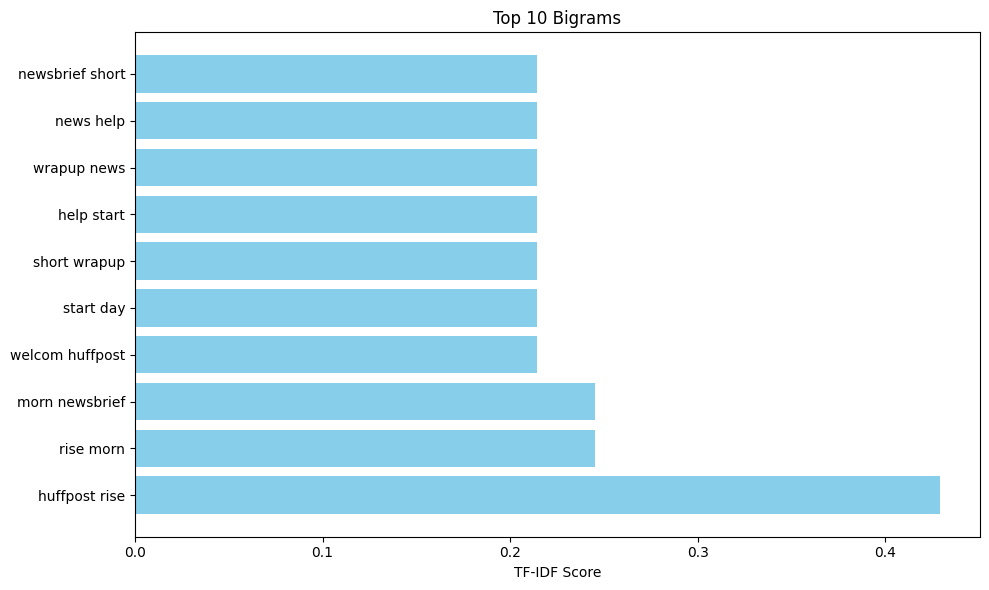

In [ ]:
# Bigram analysis for first all categories using tfidf
def top_n_bigrams(text, n=10):
    vectorizer = TfidfVectorizer(ngram_range=(2, 2), stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([text])
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()[0]
    top_n_indices = np.argsort(tfidf_scores)[-n:][::-1]
    return [(feature_names[i], tfidf_scores[i]) for i in top_n_indices]

# Generate bigrams for first all categories
df_bigram = df[df['text'].isin(df['text'].value_counts().index[:35])]
if not df_bigram.empty:
    categories = df_bigram['text'].unique()
    bigrams = top_n_bigrams(' '.join(df_bigram['text'].fillna('').astype(str)), n=10)

    # Creating a dataframe to store bigrams and their scores
    df_bigram_plots = pd.DataFrame({'Bigram': [bigram for bigram, _ in bigrams], 'Score': [score for _, score in bigrams]})

    # Plotting the bigrams
    plt.figure(figsize=(10, 6))
    plt.barh(df_bigram_plots['Bigram'], df_bigram_plots['Score'], color='skyblue')
    plt.xlabel('TF-IDF Score')
    plt.title('Top 10 Bigrams')
    plt.tight_layout()
    plt.savefig('../outputs/plots/top_10_bigrams_Articles.png')
    plt.show()
else:
    print("No data available for bigram analysis.")




In [42]:
# Sentiment analysis

# Drop rows with NaN in the 'text' column
df = df.dropna(subset=['text']).reset_index(drop=True)

sia = SentimentIntensityAnalyzer()
res = {}

# Iterate through rows
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    text = row['text']
    sentiment = sia.polarity_scores(text)
    res[index] = sentiment


100%|██████████| 209512/209512 [00:25<00:00, 8073.45it/s]


In [43]:
vaders = pd.DataFrame(res).T.reset_index().rename(columns={'index': 'category'})
vaders.head()

,category,neg,neu,pos,compound
0,0,0.064,0.936,0.000,-0.1280
1,1,0.202,0.798,0.000,-0.6486
2,2,0.000,0.735,0.265,0.5574
3,3,0.196,0.507,0.297,0.4588
4,4,0.344,0.656,0.000,-0.8750


In [44]:
vaders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209512 entries, 0 to 209511
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   category  209512 non-null  int64  
 1   neg       209512 non-null  float64
 2   neu       209512 non-null  float64
 3   pos       209512 non-null  float64
 4   compound  209512 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 8.0 MB


In [45]:
# Polarity Score function

def polarity_score(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

vaders['polarity'] = vaders['compound'].apply(polarity_score)
vaders.head()


,category,neg,neu,pos,compound,polarity
0,0,0.064,0.936,0.000,-0.1280,negative
1,1,0.202,0.798,0.000,-0.6486,negative
2,2,0.000,0.735,0.265,0.5574,positive
3,3,0.196,0.507,0.297,0.4588,positive
4,4,0.344,0.656,0.000,-0.8750,negative


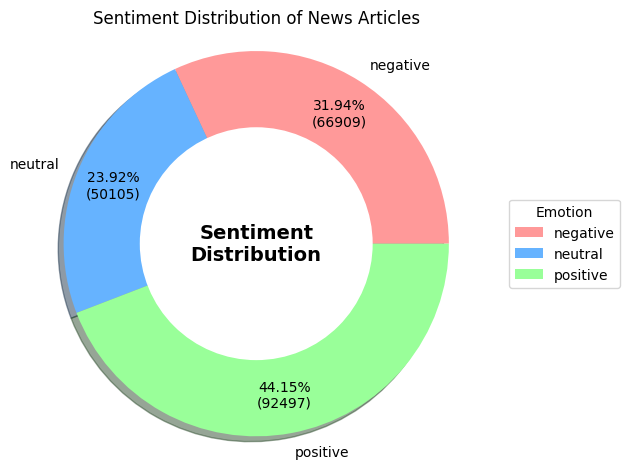

In [46]:
# Plotting the sentiment distribution

unique_emotion = vaders['polarity'].unique()
colors= ['#ff9999','#66b3ff','#99ff99']
explode = [0] * len(unique_emotion)
emotion_counts = vaders.groupby("polarity").size()
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    x=emotion_counts, 
    labels=emotion_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(emotion_counts)/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="black"),  
    pctdistance=0.8,
    explode=explode,  
    shadow=True,
    colors=colors
)
center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)
ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold')
ax.legend(emotion_counts.index, title="Emotion", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax.axis('equal') 
plt.title('Sentiment Distribution of News Articles')
plt.tight_layout()
plt.savefig('../Outputs/plots/Sentiment_Distribution_of_News_Articles.png') 
plt.show()

In [48]:
# Save the vaders DataFrame to a CSV file
vaders.to_csv('../data/vaders.csv', index=False)